# Blackjack example

<b> Example 5.1 from [Sutton and Barto book](http://incompleteideas.net/book/RLbook2020.pdf)</b>.

<i>The object of the popular casino card game of blackjack is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. We consider the version in which each player competes independently against the dealer. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust ). If he goes bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21.</i>

In [1]:
using ReinforcementLearning, ReinforcementLearningEnvironments
using PyPlot

Firstly, we will define our environment, code is based on [this](https://juliareinforcementlearning.org/ReinforcementLearningAnIntroduction.jl/notebooks/Chapter05_Blackjack.html) example.

In [2]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
DECK = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

mutable struct BlackjackEnv <: AbstractEnv
    dealer_hand::Vector{Int}
    player_hand::Vector{Int}
    done::Bool
    reward::Int
    init::Union{Tuple{Vector{Int}, Vector{Int}}, Nothing}
end

In [3]:
function BlackjackEnv(;init=nothing)
    env = BlackjackEnv([], [], false, 0., init)
    reset!(env)
    env
end

BlackjackEnv

In [4]:
RLBase.state_space(env::BlackjackEnv) = Space([Base.OneTo(31), Base.OneTo(10), Base.OneTo(2)])
RLBase.action_space(env::BlackjackEnv) = Base.OneTo(2)

usable_ace(hand) = (1 in hand) && (sum(hand) + 10 <= 21)
sum_hand(hand) = usable_ace(hand) ? sum(hand) + 10 : sum(hand)
is_bust(hand) = sum_hand(hand) > 21
score(hand) = is_bust(hand) ? 0 : sum_hand(hand)

RLBase.state(env::BlackjackEnv) = (sum_hand(env.player_hand), env.dealer_hand[1], usable_ace(env.player_hand)+1)
RLBase.reward(env::BlackjackEnv) = env.reward
RLBase.is_terminated(env::BlackjackEnv) = env.done

function RLBase.reset!(env::BlackjackEnv)
    empty!(env.dealer_hand)
    empty!(env.player_hand)
    if isnothing(env.init)
        push!(env.dealer_hand, rand(DECK))
        push!(env.dealer_hand, rand(DECK))
        while sum_hand(env.player_hand) < 12
            push!(env.player_hand, rand(DECK))
        end
    else
        append!(env.player_hand, env.init[1])
        append!(env.dealer_hand, env.init[2])
    end
    env.done=false
    env.reward = 0.
end

In [5]:
function (env::BlackjackEnv)(action)
    if action == 1
        push!(env.player_hand, rand(DECK))
        if is_bust(env.player_hand)
            env.done = true
            env.reward = -1
        else
            env.done = false
            env.reward = 0
        end
    elseif action == 2
        env.done = true
        while sum_hand(env.dealer_hand) < 17
            push!(env.dealer_hand, rand(DECK))
        end
        env.reward = cmp(score(env.player_hand), score(env.dealer_hand))
    else
        @error "unknown action"
    end
end

In [6]:
env = BlackjackEnv()

# BlackjackEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{Base.OneTo{Int64}}}(Base.OneTo{Int64}[Base.OneTo(31), Base.OneTo(10), Base.OneTo(2)])`

## Action Space

`Base.OneTo(2)`

## Current State

```
(20, 10, 2)
```


Define Agent:

In [7]:
mutable struct Agent
    env::AbstractEnv
    ϵ::Float64
    β::Float64 #stopa dyskonta
    Q::Dict #macierz wartosci dla kazdej z par:stan,akcja
    C::Dict #macierz wystapien dla kazdej z par:stan,akcja
end

function Agent(env; ϵ = .1, β = 1.0)
    return Agent(env, ϵ, β, Dict(), Dict())
end

Agent

and learning function:

In [8]:
function get_episode(agent; es = false, maxstep = 1000)
    step = 1
    S = state(agent.env)
    if !haskey(agent.Q, S) || rand() < agent.ϵ || es
        A = rand(1:length(action_space(agent.env))) 
    else
        A = argmax(agent.Q[S])
    end
    agent.env(A)
    r = reward(agent.env)
    episode = [(S, A, r)]
    if is_terminated(agent.env) 
        reset!(agent.env)
        return episode
    end
    while step < maxstep
        S = state(agent.env)
        if !haskey(agent.Q, S) || (rand() < agent.ϵ && !es)
            A = rand(1:length(action_space(agent.env))) 
        else
            A = argmax(agent.Q[S])
        end            
        agent.env(A)
        r = reward(agent.env)
        push!(episode, (S, A,r))
        if is_terminated(agent.env)
            reset!(agent.env)
            break
        end
        step +=1
    end
    return episode
end

function update!(agent; es = false)
    episode = get_episode(agent, es = es)
    R = 0
    occur_first = reverse(vcat(findfirst.(isequal.(unique(episode)), [episode]), length(episode) + 1))
    for k = 2:length(occur_first)
        for i = occur_first[k-1] - 1:-1:occur_first[k]
            S,A,r = episode[i]
            R = agent.β*R + r
        end
        S,A,r = deepcopy(episode[occur_first[k]])
        if !haskey(agent.Q, S)
            agent.C[S] = zeros(length(action_space(agent.env)))
            agent.Q[S] = zeros(length(action_space(agent.env)))
        end
        agent.C[S][A] += 1.0
        agent.Q[S][A] += (R - agent.Q[S][A])/ agent.C[S][A]
    end  
    episode[end][3] == 1.0 ? (return 1.0) : (return 0.0)
end

function MC!(agent; es = false, maxit = 500000)
    iter = 0
    successes = 0.0
    success_rate = []
    while iter < maxit
        successes += update!(agent, es = es)
        push!(success_rate, successes/iter)
        iter +=1
    end
    return success_rate
end

MC! (generic function with 1 method)

### Experiment 1: Monte Carlo control without exploring starts

In [9]:
agent = Agent(env)

success_rate = MC!(agent, maxit = 5_000_000);

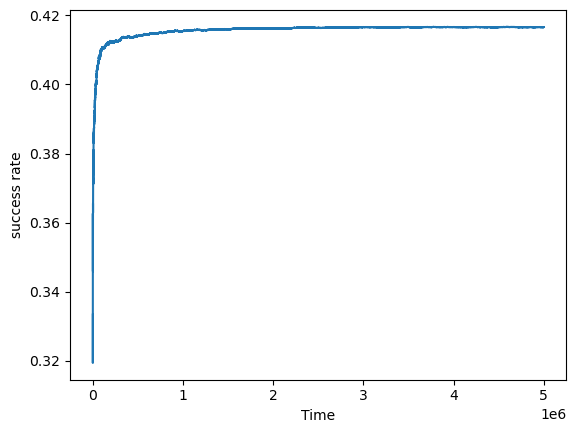

PyObject Text(24.000000000000007, 0.5, 'success rate')

In [10]:
plot(success_rate[100:5_000_000])
xlabel("Time")
ylabel("success rate")



Let us plot the value function approximation:

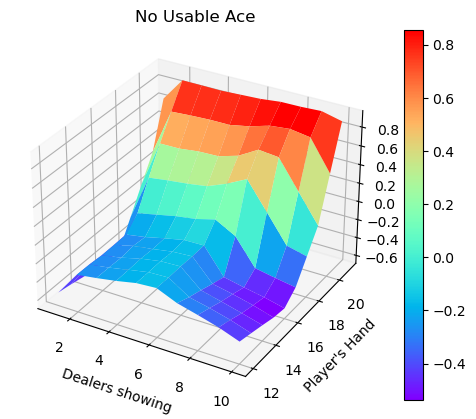

PyObject <matplotlib.colorbar.Colorbar object at 0x000001CE0DA5BA50>

In [11]:
cm = get_cmap(:gray)
p = plot_surface(1:10, 12:21, [maximum(agent.Q[(i,j,1)]) 
        for i in 12:21, j in 1:10], cmap = get_cmap("rainbow") )
ylabel("Player's Hand")
xlabel("Dealers showing")
title("No Usable Ace")
colorbar(p)

and strategy surface (white - hit, black - stick):

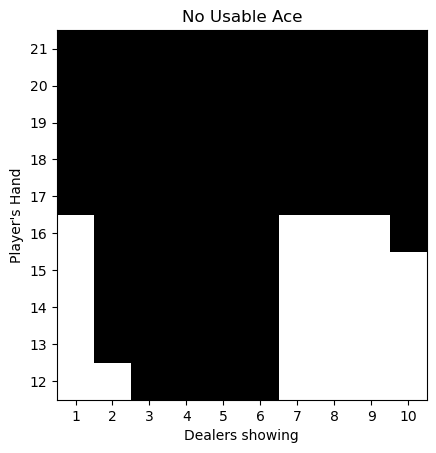

PyObject Text(0.5, 1.0, 'No Usable Ace')

In [12]:
imshow([argmax(agent.Q[(i,j,1)]) for i in 21:-1:12, j in 1:10], cmap = get_cmap("gray_r"))
yticks(0:9,string.(collect(21:-1:12)))
xticks(0:9,string.(collect(1:10)))
ylabel("Player's Hand")
xlabel("Dealers showing")
title("No Usable Ace")


We will repeat the experiment, this time with a usable Ace:

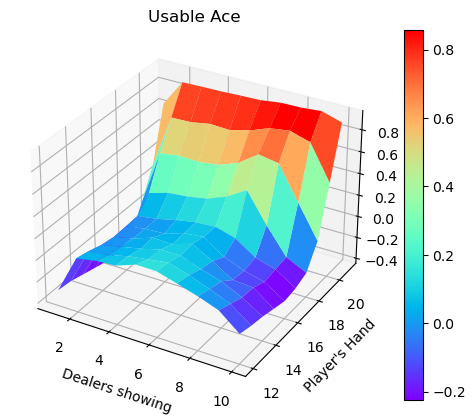

PyObject <matplotlib.colorbar.Colorbar object at 0x000001CE0DC34AD0>

In [13]:
cm = get_cmap(:gray)
p = plot_surface(1:10, 12:21, [maximum(agent.Q[(i,j,2)]) for i in 12:21, j in 1:10], cmap = get_cmap("rainbow") )
ylabel("Player's Hand")
xlabel("Dealers showing")
title("Usable Ace")
colorbar(p)

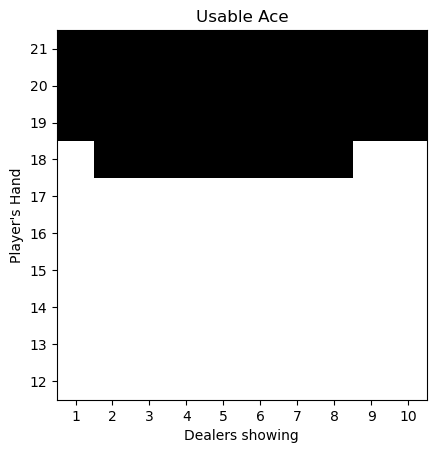

PyObject Text(0.5, 1.0, 'Usable Ace')

In [14]:
imshow([argmax(agent.Q[(i,j,2)]) for i in 21:-1:12, j in 1:10], cmap = get_cmap("gray_r"))
yticks(0:9,string.(collect(21:-1:12)))
xticks(0:9,string.(collect(1:10)))
ylabel("Player's Hand")
xlabel("Dealers showing")
title("Usable Ace")


### Experiment 2: Monte Carlo control with exploring starts

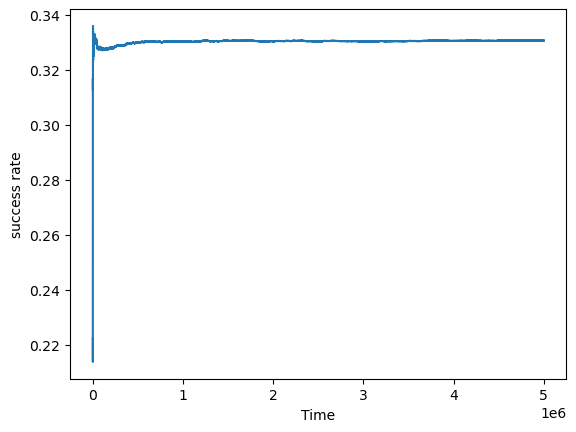

PyObject Text(24.000000000000007, 0.5, 'success rate')

In [20]:
agent2 = Agent(env)

success_rate2 = MC!(agent2, es = true, maxit = 5_000_000);

plot(success_rate2[100:5_000_000])
xlabel("Time")
ylabel("success rate")


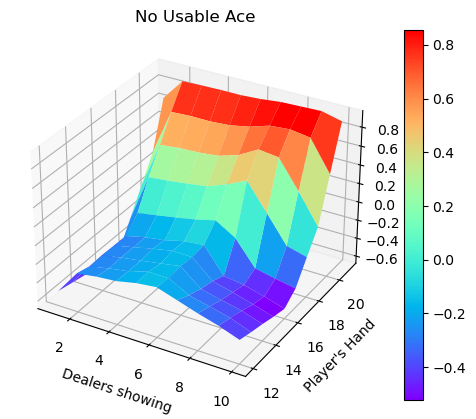

PyObject <matplotlib.colorbar.Colorbar object at 0x000001CECC814AD0>

In [21]:

p = plot_surface(1:10, 12:21, [maximum(agent2.Q[(i,j,1)]) for i in 12:21, j in 1:10], cmap = get_cmap("rainbow") )
ylabel("Player's Hand")
xlabel("Dealers showing")
title("No Usable Ace")
colorbar(p)

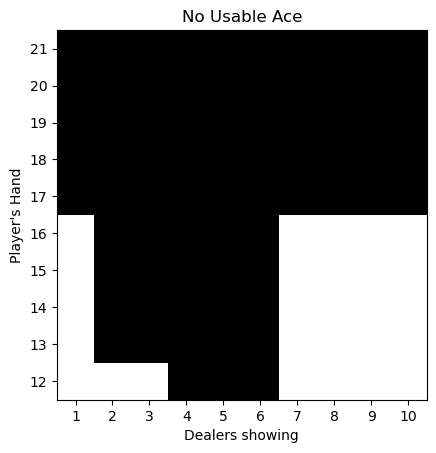

PyObject Text(0.5, 1.0, 'No Usable Ace')

In [22]:
imshow([argmax(agent2.Q[(i,j,1)]) for i in 21:-1:12, j in 1:10], cmap = get_cmap("gray_r"))
yticks(0:9,string.(collect(21:-1:12)))
xticks(0:9,string.(collect(1:10)))
ylabel("Player's Hand")
xlabel("Dealers showing")
title("No Usable Ace")

and usable Ace:

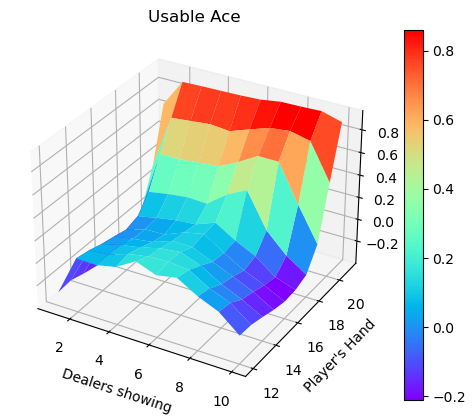

PyObject <matplotlib.colorbar.Colorbar object at 0x000001CECCA8BC50>

In [23]:
cm = get_cmap(:gray)
p = plot_surface(1:10, 12:21, [maximum(agent2.Q[(i,j,2)]) for i in 12:21, j in 1:10], cmap = get_cmap("rainbow") )
ylabel("Player's Hand")
xlabel("Dealers showing")
title("Usable Ace")
colorbar(p)



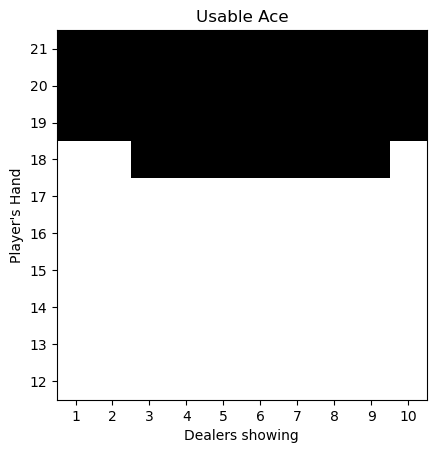

PyObject Text(0.5, 1.0, 'Usable Ace')

In [24]:
imshow([argmax(agent2.Q[(i,j,2)]) for i in 21:-1:12, j in 10:-1:1], cmap = get_cmap("gray_r"))
yticks(0:9,string.(collect(21:-1:12)))
xticks(0:9,string.(collect(1:10)))
ylabel("Player's Hand")
xlabel("Dealers showing")
title("Usable Ace")